<h1> Campaign response </h1>

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

<h2> Import Library and dataset</h2>

In [2]:
!pip install imblearn

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [23]:
df = pd.read_excel("marketing_campaign.xlsx")
df.info()
df.shape #Note: ที่ column income จะเห็นว่า Non-Null Count ไม่เท่ากับ 2240 คือ มี missing values 24 ตัว

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

(2240, 29)

In [24]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


<h2>EDA Sanity check</h2>

In [25]:
df['ID'].duplicated().sum() #ไม่มี ID ซ้ำนะจ้ะ

0

In [26]:
df.isnull().sum().sum()

24

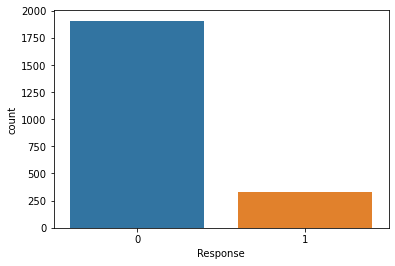

0    1906
1     334
Name: Response, dtype: int64

In [27]:
sns.countplot(x= 'Response', data = df) #Imbalance มากๆ algo จะ predict ไม่ตอบรับเยอะกว่านะ
plt.show()
df['Response'].value_counts()

จาก df จะเห็นว่ามีข้อมูลให้เลือกใช้มากมาย ไม่ว่าจะเป็น ..... แต่ ณที่นี้จะเลือก model ทางการตลาดมาใช้ คือ rfm โดยใน df มีข้อมูลพร้อมแล้วเหลือแค่ต้อง transform บางตัว

<h3>Feature Engineering</h3>

ใช้ rfm framework การทำต่อ
spending = monetory
transaction = frequency
recency มีมาให้แล้วจ้า

In [28]:
df['Spending']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']
df['Transactions']=df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']
df=df[['ID','Spending','Transactions','Recency','Response']]

In [29]:
print('There are {} rows and {} columns'.format(df.shape[0], df.shape[1]))
df.describe()

There are 2240 rows and 5 columns


,ID,Spending,Transactions,Recency,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,605.798214,12.537054,49.109375,0.149107
std,3246.662198,602.249288,7.205741,28.962453,0.356274
min,0.000000,5.000000,0.000000,0.000000,0.000000
25%,2828.250000,68.750000,6.000000,24.000000,0.000000
50%,5458.500000,396.000000,12.000000,49.000000,0.000000
75%,8427.750000,1045.500000,18.000000,74.000000,0.000000
max,11191.000000,2525.000000,32.000000,99.000000,1.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            2240 non-null   int64
 1   Spending      2240 non-null   int64
 2   Transactions  2240 non-null   int64
 3   Recency       2240 non-null   int64
 4   Response      2240 non-null   int64
dtypes: int64(5)
memory usage: 87.6 KB


In [31]:
df.head()

,ID,Spending,Transactions,Recency,Response
0,5524,1617,22,58,1
1,2174,27,4,38,0
2,4141,776,20,26,0
3,6182,53,6,26,0
4,5324,422,14,94,0


ใช้วัดถัดมาจากวันสุดท้ายของ dataset เป็น next campagin date

<h3>Prediction</h3>

In [94]:
def campaign_response(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.7, shuffle = True, random_state = 1)
    
    sm = SMOTE(random_state = 1)
    x_sm, y_sm = sm.fit_resample(x_train, y_train)
    
    xgb_model = xgb.XGBClassifier(objectives='binary:logistic', eval_metrics = 'auc')
    xgb_model.fit(x_sm, y_sm, early_stopping_rounds = 5, eval_set = [(x_test, y_test)])
    print('--------------------------')
    
    y_train_predict = xgb_model.predict(x_sm)
    print('Train Result')
    print(classification_report(y_sm, y_train_predict))
    
    y_test_predict = xgb_model.predict(x_test)
    print('Test Result')
    print(classification_report(y_test, y_test_predict))
    
    plt.figure(figsize=(10,6))
    y_prob_sm = xgb_model.predict_proba(x_sm)
    fpr_train, tpr_train,_ = metrics.roc_curve(y_sm, y_prob_sm[:,1])
    auc_train = roc_auc_score(y_sm, y_prob_sm[:,1])
    
    plt.plot(fpr_train, tpr_train, color = 'red', label=f'Train set = {auc_train:.2f}')
    
    y_prob_test = xgb_model.predict_proba(x_test.to_numpy())
    fpr_test, tpr_test,_ = metrics.roc_curve(y_test, y_prob_test[:,1])
    auc_test = roc_auc_score(y_test, y_prob_test[:,1])

    plt.plot(fpr_test, tpr_test, color = 'blue', label=f'Test set = {auc_test:.3f}')
    plt.legend()
    plt.title('RoC')
    plt.show();

   Spending  Transactions  Recency
0      1617            22       58
1        27             4       38
2       776            20       26
3        53             6       26
4       422            14       94
0    1
1    0
2    0
3    0
4    0
Name: Response, dtype: int64
[03:24:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "eval_metrics", "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.62678
[1]	validation_0-logloss:0.58971
[2]	validation_0-logloss:0.56673
[3]	validation_0-logloss:0.55215
[4]	validation_0-logloss:0.54932
[5]	validation_0-logloss:0.54951
[6]	validation_0-logloss:0.55004
[7]	validation_0-logloss:0.54

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


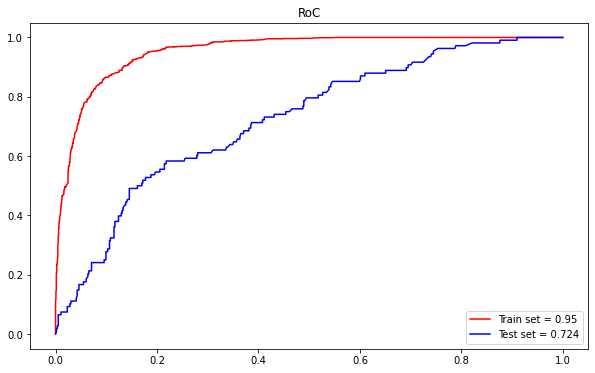

In [95]:
y = df['Response']
x = df.drop(['Response', 'ID'], axis = 1)
print(x.head())
print(y.head())
campaign_response(x,y)